# **Vrinda Store Sales Data Analysis**

## Problem Statement:
1. Import and Clean Sales data

2. Calculate
Total amount and number of orders completed,
Total amount and number of orders returned/cancelled,
Return Rate,
Average order size,
Amount Spent by Women and Men.

3. Perform Customer Demographics Analysis.

4. Explore seasonal trends by month.

5. Evaluate Product and Platform performance.

6. Find out the best and worst performing product categories.

7. Compare B2B and B2C orders.

8. Plot sales amount data on map of India.

9. Find out if there is preference for a specific product in Age Groups.

## **Importing Necessary Libraries and Dataset**

In [58]:
## Import Libraries, set pandas dataframe max columns to 200, set matplotlib to inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',200)
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/vrinda-store-dataset/Vrinda Store Data Analysis.xlsx
/kaggle/input/vrinda-store-dataset/india-polygon.shx
/kaggle/input/vrinda-store-dataset/india-polygon.shp
/kaggle/input/vrinda-store-dataset/india-polygon.dbf


In [59]:
## Import data using pandas
path = r"/kaggle/input/vrinda-store-dataset/Vrinda Store Data Analysis.xlsx"
data = pd.read_excel(path, sheet_name='Vrinda Store', index_col=0, parse_dates=True, date_format="%d-%m-%Y")
print(data.shape)
data.head()

(28362, 15)


,Order ID,Cust ID,Gender,Age,Order Date,Status,Platform,Category,Size,Quantity,Amount,City,State,Pin Code,B2B
Index,,,,,,,,,,,,,,,
1,408-8573929-1921943,8573929,Women,46,2022-12-04,Delivered,Amazon,kurta,M,1,729,kolkata,WEST BENGAL,700082,False
2,407-8980704-1408352,8980704,Women,59,2022-12-04,Cancelled,Myntra,kurta,M,1,345,NOIDA,UTTAR PRADESH,201304,False
3,171-2516658-6849136,2516658,Women,55,2022-12-04,Delivered,Flipkart,kurta,M,1,481,CHENNAI,TAMIL NADU,600077,False
4,404-0105497-2446747,105497,Women,37,2022-12-04,Refunded,Amazon,kurta,S,1,382,BHANDARA,MAHARASHTRA,441701,False
5,406-6468339-1490707,6468339,Men,19,2022-12-04,Delivered,Amazon,Set,XS,1,1036,MUMBAI,MAHARASHTRA,400093,False


# **1. Data Cleaning and Transformation**

In [60]:
## Drop ID columns and Pin Code
data.drop(columns=['Order ID', 'Cust ID', 'Pin Code'], inplace = True)

In [61]:
## Extract only month from Order Date
data['Order Date'] = data['Order Date'].dt.month
data.rename(columns={"Order Date":"Order Month"}, inplace=True)

## Check latest and oldest order dates
print(" Oldest Order Month: ", data['Order Month'].min(), "\n", "Latest Order Month: ", data['Order Month'].max())

 Oldest Order Month:  1 
 Latest Order Month:  12


In [62]:
## Describe numerical features
data.describe()

,Age,Order Month,Amount
count,28362.000000,28362.000000,28362.000000
mean,39.502503,6.322474,685.569812
std,15.147138,3.428511,268.322064
min,18.000000,1.000000,229.000000
25%,27.000000,3.000000,487.000000
50%,37.000000,6.000000,650.000000
75%,47.000000,9.000000,799.000000
max,78.000000,12.000000,3036.000000


In [63]:
## Describe categorical features
data.describe(include='object')

,Gender,Status,Platform,Category,Size,Quantity,City,State
count,28362,28362,28362,28362,28362,28362,28362,28362
unique,4,4,7,8,11,7,2546,49
top,Women,Delivered,Amazon,Set,M,1,BENGALURU,MAHARASHTRA
freq,19520,26153,10062,11483,4998,28219,2329,4114


In [64]:
## Check data types and number of non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28362 entries, 1 to 28362
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Gender       28362 non-null  object
 1   Age          28362 non-null  int64 
 2   Order Month  28362 non-null  int32 
 3   Status       28362 non-null  object
 4   Platform     28362 non-null  object
 5   Category     28362 non-null  object
 6   Size         28362 non-null  object
 7   Quantity     28362 non-null  object
 8   Amount       28362 non-null  int64 
 9   City         28362 non-null  object
 10  State        28362 non-null  object
 11  B2B          28362 non-null  bool  
dtypes: bool(1), int32(1), int64(2), object(8)
memory usage: 2.5+ MB


In [65]:
## Quantity is of object type, it should be integer
data['Quantity'].unique()

array([1, 2, 4, 3, 'Two', 5, 'One'], dtype=object)

In [66]:
## Replace text with integer value
data['Quantity'].replace('Two',2, inplace = True)
data['Quantity'].replace('One',1, inplace = True)
data['Quantity'].unique()

array([1, 2, 4, 3, 5])

In [67]:
## Change True-False of B2B column to B2B or B2C 
data.rename(columns={"B2B":"Type of Transaction"}, inplace=True)
data['Type of Transaction'].replace(True, "B2B", inplace=True)
data['Type of Transaction'].replace(False, "B2C", inplace=True)
data['Type of Transaction'].unique()

array(['B2C', 'B2B'], dtype=object)

In [68]:
## Check for duplicate data
data.duplicated().sum()
data.drop_duplicates(keep='first', inplace=True)
data.shape

(28359, 12)

In [69]:
## Check unique values in Gender
data['Gender'].unique()

array(['Women', 'Men', 'W', 'M'], dtype=object)

In [70]:
## Replace M and W with men and women
data['Gender'].replace("W", "Women", inplace=True)
data['Gender'].replace("M", "Men", inplace=True)
data['Gender'].unique()

array(['Women', 'Men'], dtype=object)

In [71]:
## Make Age group column
bins= [17, 25, 36, 46, 55, 100]
labels = ["Youth", "Young Adults", "Middle Age Adult", "Senior", "Elderly"]
data['Age Group'] = pd.cut(data['Age'], bins = bins, labels=labels)
data = data[data.columns[[0,1,12,2,3,4,5,6,7,8,9,10,11]]]
data.head()

,Gender,Age,Age Group,Order Month,Status,Platform,Category,Size,Quantity,Amount,City,State,Type of Transaction
Index,,,,,,,,,,,,,
1,Women,46,Middle Age Adult,12,Delivered,Amazon,kurta,M,1,729,kolkata,WEST BENGAL,B2C
2,Women,59,Elderly,12,Cancelled,Myntra,kurta,M,1,345,NOIDA,UTTAR PRADESH,B2C
3,Women,55,Senior,12,Delivered,Flipkart,kurta,M,1,481,CHENNAI,TAMIL NADU,B2C
4,Women,37,Middle Age Adult,12,Refunded,Amazon,kurta,S,1,382,BHANDARA,MAHARASHTRA,B2C
5,Men,19,Youth,12,Delivered,Amazon,Set,XS,1,1036,MUMBAI,MAHARASHTRA,B2C


In [72]:
## Check Unique Values in Status
data['Status'].unique()

array(['Delivered', 'Cancelled', 'Refunded', 'Returned'], dtype=object)

In [73]:
## Check Unique Values in Platform
data['Platform'].unique()

array(['Amazon', 'Myntra', 'Flipkart', 'Meesho', 'Others', 'Nalli',
       'Ajio'], dtype=object)

In [74]:
## Capitilize all values in Category
data['Category'] = data['Category'].str.capitalize()
data['Category'].unique()

array(['Kurta', 'Set', 'Saree', 'Western dress', 'Top', 'Blouse',
       'Ethnic dress', 'Bottom'], dtype=object)

In [75]:
## Check Unique Values in Size
data['Size'].unique()

array(['M', 'S', 'XS', 'L', 'XL', 'Free', 'XXL', '3XL', '6XL', '4XL',
       '5XL'], dtype=object)

In [76]:
## Check number of states, it should be 36 or less
print("Number of States: ", data['State'].nunique())
print(np.sort(data['State'].unique()))

Number of States:  49
['ANDAMAN & NICOBAR ' 'ANDHRA PRADESH' 'ARUNACHAL PRADESH' 'ASSAM'
 'Arunachal Pradesh' 'Arunachal pradesh' 'BIHAR' 'Bihar' 'CHANDIGARH'
 'CHHATTISGARH' 'Chandigarh' 'DADRA AND NAGAR' 'DELHI' 'Delhi' 'GOA'
 'GUJARAT' 'Goa' 'HARYANA' 'HIMACHAL PRADESH' 'JAMMU & KASHMIR'
 'JHARKHAND' 'KARNATAKA' 'KERALA' 'LADAKH' 'MADHYA PRADESH' 'MAHARASHTRA'
 'MANIPUR' 'MEGHALAYA' 'MIZORAM' 'Manipur' 'NAGALAND' 'New Delhi' 'ODISHA'
 'PUDUCHERRY' 'PUNJAB' 'Punjab' 'RAJASTHAN' 'SIKKIM' 'Sikkim' 'TAMIL NADU'
 'TELANGANA' 'TRIPURA' 'UTTAR PRADESH' 'UTTARAKHAND' 'WEST BENGAL' 'bihar'
 'delhi' 'goa' 'punjab']


In [77]:
## Higher number due to uppercase and lowercase values, set all to capital case
data['State'] = data['State'].str.capitalize()
data['State'].replace('New delhi','Delhi', inplace=True)

## Check number and value of unique States
print("Number of States: ", data['State'].nunique())
print(np.sort(data['State'].unique()))

Number of States:  35
['Andaman & nicobar ' 'Andhra pradesh' 'Arunachal pradesh' 'Assam' 'Bihar'
 'Chandigarh' 'Chhattisgarh' 'Dadra and nagar' 'Delhi' 'Goa' 'Gujarat'
 'Haryana' 'Himachal pradesh' 'Jammu & kashmir' 'Jharkhand' 'Karnataka'
 'Kerala' 'Ladakh' 'Madhya pradesh' 'Maharashtra' 'Manipur' 'Meghalaya'
 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim'
 'Tamil nadu' 'Telangana' 'Tripura' 'Uttar pradesh' 'Uttarakhand'
 'West bengal']


In [78]:
## Perform same steps for City columns
print("Number of Cities before: ",data['City'].nunique())
data['City'] = data['City'].str.capitalize()
print("Number of Cities After: ",data['City'].nunique())

Number of Cities before:  2546
Number of Cities After:  1845


## 1. Cleaned data

In [116]:
#data.to_csv('vrinda_store_sales_data_clean.csv')
data.head()

,Gender,Age,Age Group,Order Month,Status,Platform,Category,Size,Quantity,Amount,City,State,Type of Transaction
Index,,,,,,,,,,,,,
1,Women,46,Middle Age Adult,12,Delivered,Amazon,Kurta,M,1,729,Kolkata,West bengal,B2C
2,Women,59,Elderly,12,Cancelled,Myntra,Kurta,M,1,345,Noida,Uttar pradesh,B2C
3,Women,55,Senior,12,Delivered,Flipkart,Kurta,M,1,481,Chennai,Tamil nadu,B2C
4,Women,37,Middle Age Adult,12,Refunded,Amazon,Kurta,S,1,382,Bhandara,Maharashtra,B2C
5,Men,19,Youth,12,Delivered,Amazon,Set,XS,1,1036,Mumbai,Maharashtra,B2C


# **Data Analysis and Visualization**

## 2. Calculate sales related KPIs

In [102]:
## Total sales
df = data[data['Status']=="Delivered"]
total_sales_completed = df['Amount'].sum()
number_of_orders = df['Quantity'].count()
total_products_sold = df['Quantity'].sum()

df_ret = data[data['Status']!="Delivered"]
total_return_amount = df_ret['Amount'].sum()

df = df.groupby('Gender')['Amount'].sum()
total_spend_m = df[0]
total_spend_f = df[1]
## Calculate percentage
m_perc = round(total_spend_m / total_sales_completed * 100,2)
f_perc = round(total_spend_f / total_sales_completed * 100,2)

## Average order size i.e. number of items in an order
order_size = round(data['Quantity'].mean(),2)

## Convert to lakhs
total_spend_m = df[0]//100000
total_spend_f = df[1]//100000
total_return_amount = total_return_amount//100000
total_sales_completed = total_sales_completed//100000

## Calculate return count and percentage
df_ret = data[(data['Status']!='Delivered')]
return_count = df_ret.shape[0]

return_rate = round(return_count/data.shape[0]*100,1)


print("Total Sales Completed this Year : {} Lakh".format(total_sales_completed))
print("Total Number of Successful Orders: {}".format(number_of_orders))
print("Average Number of Items in Single Order: {}".format(order_size), "\n")

print("Total Amount of Refunds/Cancellations: {} Lakh".format(total_return_amount))
print("Total Number of Orders Returned or Cancelled : {}".format(return_count))
print("Return rate: {}%".format(return_rate), "\n")


print("Amount Spent by Women: {} Lakhs, In Percentage = {}% ".format(total_spend_f, f_perc))
print("Amount Spent by Men: {} Lakhs, In Percentage = {}%".format(total_spend_m, m_perc))

Total Sales Completed this Year : 180 Lakh
Total Number of Successful Orders: 26150
Average Number of Items in Single Order: 1.01 

Total Amount of Refunds/Cancellations: 13 Lakh
Total Number of Orders Returned or Cancelled : 2209
Return rate: 7.8% 

Amount Spent by Women: 115 Lakhs, In Percentage = 63.96% 
Amount Spent by Men: 65 Lakhs, In Percentage = 36.04%


## 3. Distribution of number of orders in Age Groups

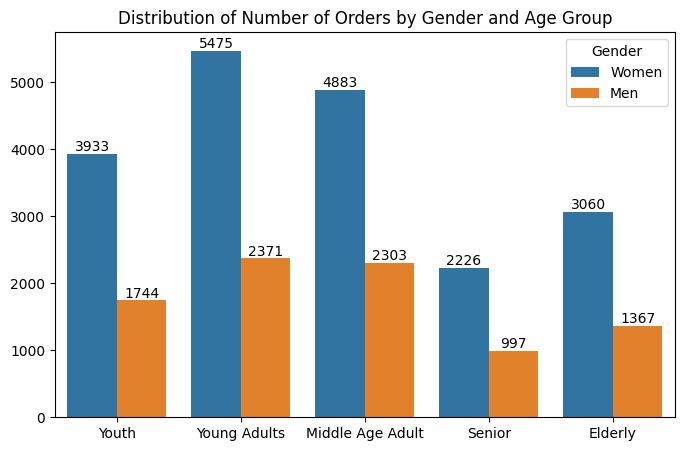

In [81]:
plt.figure(figsize=(8,5))
plt.title("Distribution of Number of Orders by Gender and Age Group")
ax = sns.countplot(data=data, x = 'Age Group', hue='Gender')
plt.xlabel("")
plt.ylabel("")
for bars in ax.containers:
    ax.bar_label(bars)

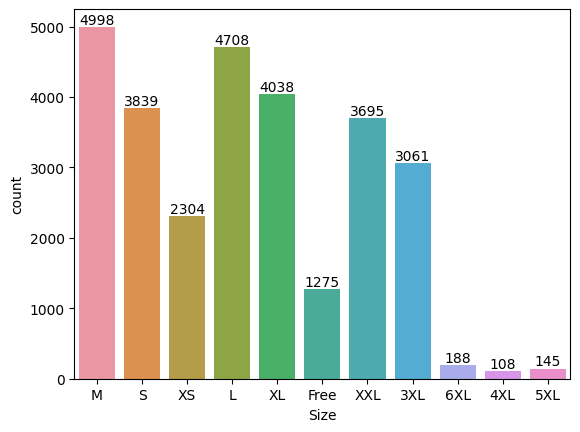

In [121]:
## Countplot of size of products
ax = sns.countplot(data=data, x='Size')
for bar in ax.containers:
    ax.bar_label(bar)

## Conclusion
Young adults and middle aged adults generate highest number of orders, while senior age group has lowest number. Products of Medium, Large, and Small sizes are sold the most. 4XL, 5XL, 6XL size products have low number of orders.

## 4. Seasonal Trends

Text(0, 0.5, '')

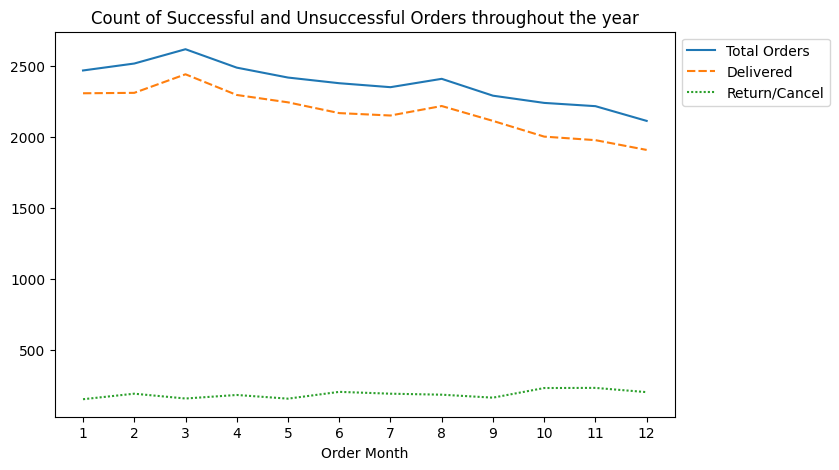

In [82]:
## Lineplot for number of orders generated, delivered and cancelled/returned.
df = data[['Order Month','Quantity','Status']].copy()
df['Delivered'] = np.where(df['Status']=="Delivered",1,0)
df['Return/Cancel'] = np.where(df['Status']!="Delivered",1,0)

df = df.groupby('Order Month')[['Quantity','Delivered','Return/Cancel']].sum()
df.rename(columns={'Quantity':'Total Orders'}, inplace=True)

plt.figure(figsize=(8,5))
plt.title("Count of Successful and Unsuccessful Orders throughout the year")
sns.lineplot(data=df)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(np.arange(1,13))
plt.ylabel("")

Text(0, 0.5, '')

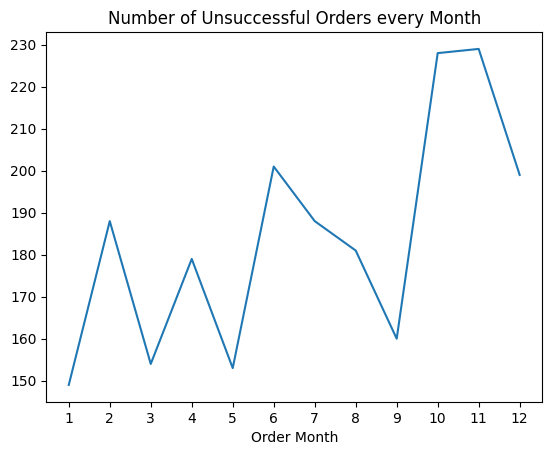

In [83]:
plt.title("Number of Unsuccessful Orders every Month")
sns.lineplot(data=df, x=df.index, y=df['Return/Cancel'])
plt.xticks(np.arange(1,13))
plt.ylabel("")

## Conclusion
Number of orders is high in Q1 and Q2 but slows down in Q3 with small increment during month of August. Q4 performance is not good.
Return rate is low during Q1, Q2 and Q3 but significantly high in Q3. Return rate is highest in October and November.

## 5. Product Category Comparison

Text(0, 0.5, 'Number of Orders')

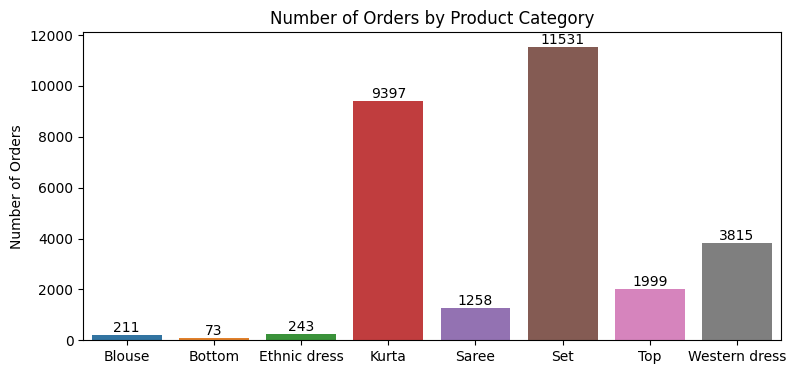

In [84]:
df = data.groupby('Category')[['Quantity','Amount']].sum()
plt.figure(figsize=(9,4))
plt.title("Number of Orders by Product Category")
ax = sns.barplot(data=df, x=df.index, y='Quantity')
for bars in ax.containers:
    ax.bar_label(bars)
plt.xlabel("")
plt.ylabel("Number of Orders")

Text(0, 0.5, 'Percentage of Orders of Returned')

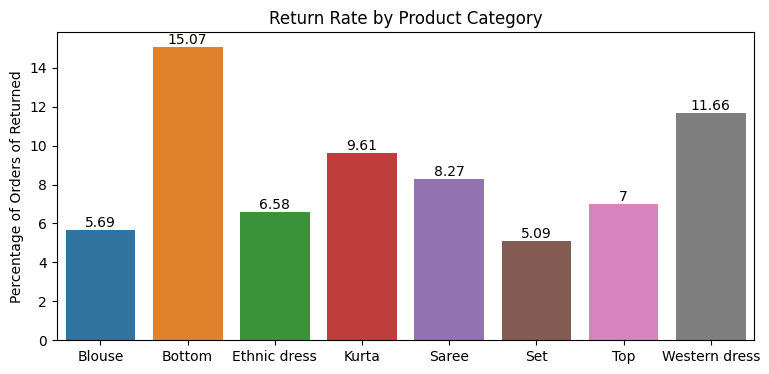

In [85]:
## Total Sales of each Product Category
total_df = data.groupby('Category')['Quantity'].sum()
total_df.reset_index()

## Total Returns of each Product Category
return_df = data[data['Status']!="Delivered"]
return_df = return_df.groupby('Category')['Quantity'].sum()
return_df.reset_index()

## Merge both dataframes
df = pd.DataFrame(pd.merge(total_df, return_df, how='inner', on='Category'))
df.rename(columns={'Quantity_x':'Total Orders', 'Quantity_y':'Returns'}, inplace=True)
df['Return Rate'] = round(df['Returns']/df['Total Orders'] * 100,2)

plt.figure(figsize=(9,4))
plt.title("Return Rate by Product Category")
ax = sns.barplot(data=df, x=df.index, y='Return Rate')
for bars in ax.containers:
    ax.bar_label(bars)
plt.xlabel("")
plt.ylabel("Percentage of Orders of Returned")

Text(0.5, 0, 'Order Month')

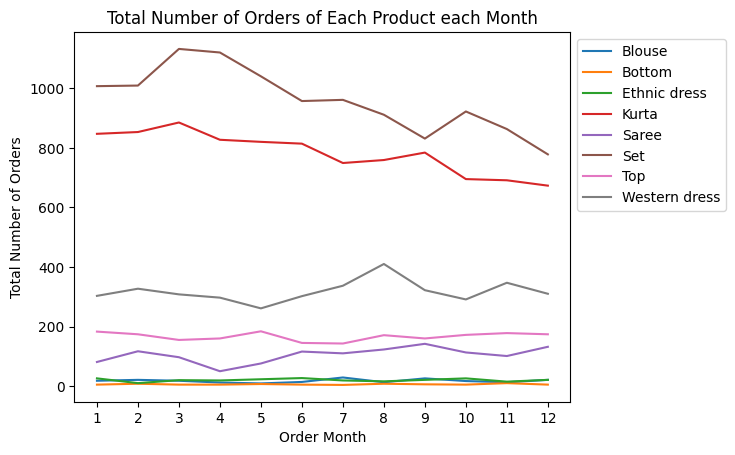

In [86]:
df = data.groupby(['Order Month','Category'])['Quantity'].agg(['sum'])
plt.title("Total Number of Orders of Each Product each Month")
sns.lineplot(data=df, x='Order Month', y='sum', hue='Category')
plt.xticks(np.arange(1,13))
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.ylabel("Total Number of Orders")
plt.xlabel("Order Month")

Text(0.5, 0, 'Order Month')

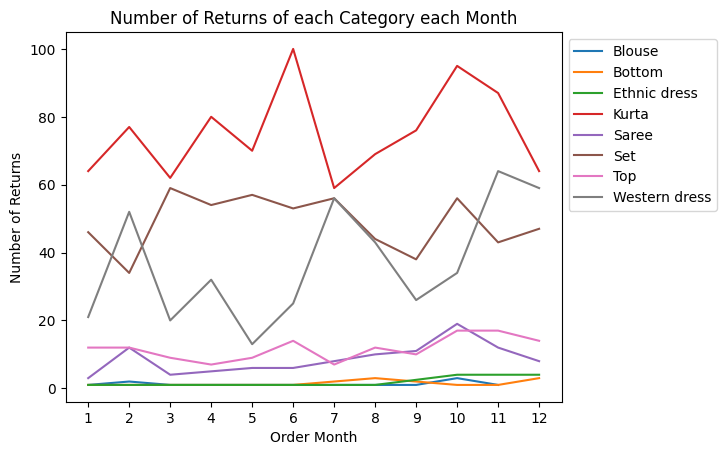

In [87]:
## Return count of each category by Month
df = data[data['Status']!="Delivered"]
df = df.groupby(['Order Month','Category'])['Quantity'].agg(['sum'])

plt.title("Number of Returns of each Category each Month")
sns.lineplot(data=df, x='Order Month', y='sum', hue='Category')
plt.xticks(np.arange(1,13))
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.ylabel("Number of Returns")
plt.xlabel("Order Month")

## Conclusion
Set and Kurta are best selling products throughout the year. But Kurta product category has more number of returns.
hence Set is the best selling category with highest sales and lowest return rate.
Order quantity of bottoms, ethnic dresses and blouse is among lowest.
Bottoms is the worst performing product category with highest return rate.
Decrement in sales and increase in return rate after Q2 is seen again in individual category orders, with western dress and saree being small exceptions, due to relatively smaller decrement in sales after Q2.

## 6. Comparison of Sales Across Shopping Platforms

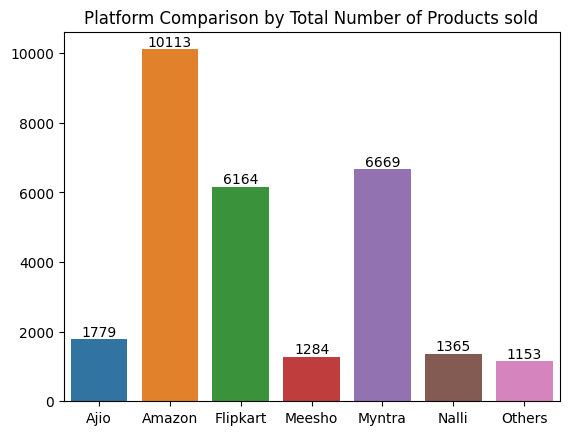

In [88]:
## Group by platform to calculate total orders
df = data.groupby('Platform')['Quantity'].agg(['sum'])

plt.title("Platform Comparison by Total Number of Products sold")
ax = sns.barplot(data=df, x=df.index, y='sum')
plt.xlabel("")
plt.ylabel("")
for bars in ax.containers:
    ax.bar_label(bars)

Text(0, 0.5, 'Percentage of Orders Returned')

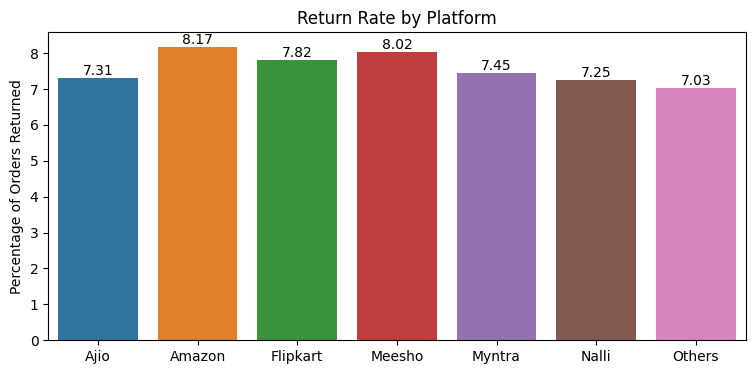

In [101]:
## Total Sales on each Platform
total_df = data.groupby('Platform')['Quantity'].sum()
total_df.reset_index()

## Total Returns from each Platform
return_df = data[data['Status']!="Delivered"]
return_df = return_df.groupby('Platform')['Quantity'].sum()
return_df.reset_index()

## Merge both dataframes
df = pd.DataFrame(pd.merge(total_df, return_df, how='inner', on='Platform'))
df.rename(columns={'Quantity_x':'Total Orders', 'Quantity_y':'Returns'}, inplace=True)
df['Return Rate'] = round(df['Returns']/df['Total Orders'] * 100,2)

plt.figure(figsize=(9,4))
plt.title("Return Rate by Platform")
ax = sns.barplot(data=df, x=df.index, y='Return Rate')
for bars in ax.containers:
    ax.bar_label(bars)
plt.xlabel("")
plt.ylabel("Percentage of Orders Returned")

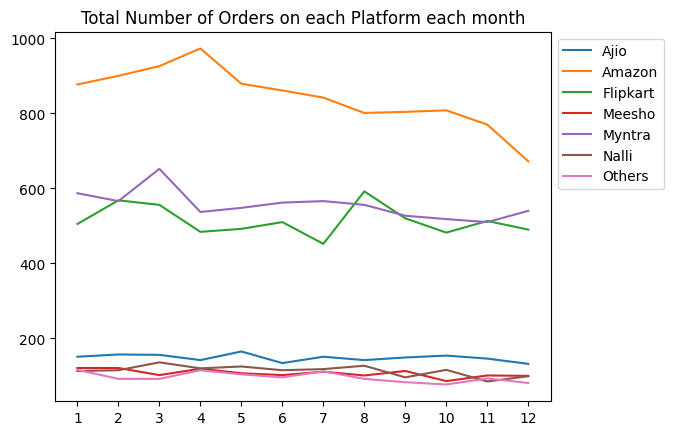

In [89]:
df = data.groupby(['Order Month','Platform'])['Quantity'].agg(['sum'])
df.reset_index()

plt.title("Total Number of Orders on each Platform each month")
ax = sns.lineplot(data=df, x='Order Month', y='sum', hue='Platform')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(np.arange(1,13))
plt.xlabel("")
plt.ylabel("")

for bars in ax.containers:
    ax.bar_label(bars)

Text(0.5, 0, 'Order Month')

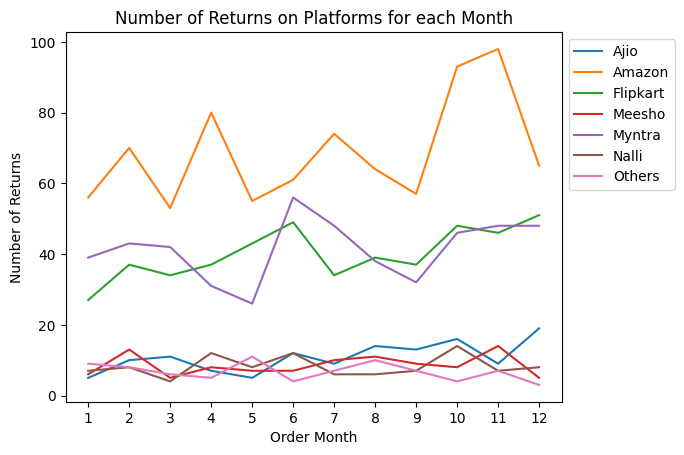

In [98]:
## Return count of each category by Month
df = data[data['Status']!="Delivered"]
df = df.groupby(['Order Month','Platform'])['Quantity'].agg(['sum'])

plt.title("Number of Returns on Platforms for each Month")
sns.lineplot(data=df, x='Order Month', y='sum', hue='Platform')
plt.xticks(np.arange(1,13))
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.ylabel("Number of Orders Returned")
plt.xlabel("Order Month")

## Conclusion
Amazon, Flipkart and Myntra are platforms with highest number of orders. Meesho, Nalli and other platforms have low number of orders.
Difference in Return rate of platforms is not large but Nalli, Ajio and Myntra have slightly lower return rate than other platforms.
Seasonal pattern of low performance after Q2 can also be observed in different platforms.

## 7. Comparison of B2B and B2C Transactions

In [105]:
total_orders = data['Quantity'].count()
df = data.groupby('Type of Transaction')['Quantity'].count()

b2b_num = df[0]
b2c_num = df[1]
b2b_perc = round(b2b_num / total_orders * 100,2)
b2c_perc = round(b2c_num / total_orders * 100,2)

print("Total Orders Made This Year : {} ".format(total_orders))
print("Total Number of Business to Business Transactions: {} , In Percentage = {}% ".format(b2b_num, b2b_perc))
print("Total Number of Business to Customer Transactions: {} , In Percentage = {}%".format(b2c_num, b2c_perc), "\n")

## Return rate of B2B orders
df_ret = data[data['Type of Transaction']=='B2B']

b2b_total_orders = df_ret['Status'].count()
b2b_returned = df_ret.query('Status!="Delivered"')['Status'].count()

return_rate_b2b = round(b2b_returned/b2b_total_orders*100,2)

print("Total number of B2B transations: {}".format(b2b_total_orders))
print("Number of unsuccessful B2B orders: {}".format(b2b_returned))
print("Return rate of B2B transations: {}%,".format(return_rate_b2b),"compared to {}% of all Orders".format(return_rate))

Total Orders Made This Year : 28359 
Total Number of Business to Business Transactions: 166 , In Percentage = 0.59% 
Total Number of Business to Customer Transactions: 28193 , In Percentage = 99.41% 

Total number of B2B transations: 166
Number of unsuccessful B2B orders: 9
Return rate of B2B transations: 5.42%, compared to 7.8% of all Orders


# 8. Mapping Total Sales Amount on Map of India

In [92]:
## Import geopandas and shapefile for plotting. Use dbf, shp, and shx files of polygon Map of India
import geopandas as gpd
import shapefile as shp

fp = r'/kaggle/input/vrinda-store-dataset/india-polygon.shp'
mp = gpd.read_file(fp)
mp.head()

,id,st_nm,geometry
0,None,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0..."
1,None,Arunachal Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612..."
2,None,Assam,"POLYGON ((95.19594 27.03612, 95.08795 26.94578..."
3,None,Bihar,"POLYGON ((88.11357 26.54028, 88.28006 26.37640..."
4,None,Chandigarh,"POLYGON ((76.84208 30.76124, 76.83758 30.72552..."


<Axes: >

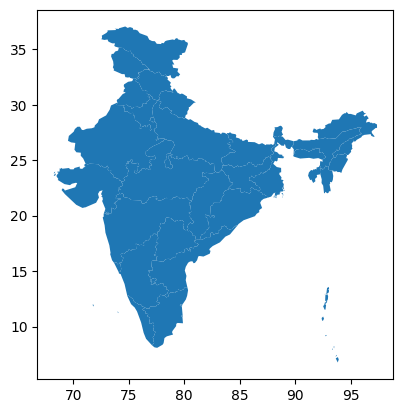

In [93]:
# Empty plot, shows map of India
mp.plot()

In [94]:
## State names from Sales data should match names from polygon data file

value = np.sort(np.array(mp['st_nm']))
key = np.sort(data['State'].unique())
value = np.delete(value,np.where((value=='Daman and Diu') | (value=='Lakshadweep')))

print(key)
print(value)

## Use dictionary to map new state names to data
dc = {key[i]:value[i] for i in range(len(key))}
print(dc)

['Andaman & nicobar ' 'Andhra pradesh' 'Arunachal pradesh' 'Assam' 'Bihar'
 'Chandigarh' 'Chhattisgarh' 'Dadra and nagar' 'Delhi' 'Goa' 'Gujarat'
 'Haryana' 'Himachal pradesh' 'Jammu & kashmir' 'Jharkhand' 'Karnataka'
 'Kerala' 'Ladakh' 'Madhya pradesh' 'Maharashtra' 'Manipur' 'Meghalaya'
 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim'
 'Tamil nadu' 'Telangana' 'Tripura' 'Uttar pradesh' 'Uttarakhand'
 'West bengal']
['Andaman and Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Dadra and Nagar Haveli'
 'Delhi' 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh' 'Jammu and Kashmir'
 'Jharkhand' 'Karnataka' 'Kerala' 'Ladakh' 'Madhya Pradesh' 'Maharashtra'
 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Punjab'
 'Rajasthan' 'Sikkim' 'Tamil Nadu' 'Telangana' 'Tripura' 'Uttar Pradesh'
 'Uttarakhand' 'West Bengal']
{'Andaman & nicobar ': 'Andaman and Nicobar Islands', 'Andhra pradesh': 'Andhra Pradesh', 

In [95]:
## Group by states and set change index to state name as per map file
df_map = data.groupby('State')['Amount'].sum()
df_map.index = df_map.index.map(dc)

## Join map data from shape file with amount data
final_map = mp.set_index('st_nm').join(df_map)
final_map.replace(np.nan,0, inplace=True)
final_map.drop(columns=['id'], inplace=True)
final_map.head()

## Final map dataframe is prepared

,geometry,Amount
st_nm,,
Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...",48656.0
Arunachal Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612...",29823.0
Assam,"POLYGON ((95.19594 27.03612, 95.08795 26.94578...",296490.0
Bihar,"POLYGON ((88.11357 26.54028, 88.28006 26.37640...",409341.0
Chandigarh,"POLYGON ((76.84208 30.76124, 76.83758 30.72552...",56651.0


<Figure size 1000x1000 with 0 Axes>

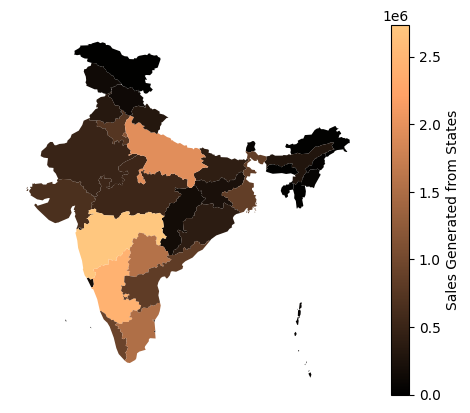

In [130]:
plt.figure(figsize=(10,10))
map_plot = final_map.plot(column='Amount',cmap='copper', legend=True, legend_kwds={'label':"Sales Generated from States"})
map_plot.set_axis_off()
#plt.savefig('India_Plot.png')

## Conclusion
States with higher amount of sales generated are represented with lighter colors.
Maharashtra, Karnataka, Uttar Pradesh are sales with highest amount spent.
States shown with dark colors have low sales amount such as Mizoram, Ladakh, Dadra and Nagar Haveli.


## 9. Age groups preference for product categories

Text(0.5, 0, '')

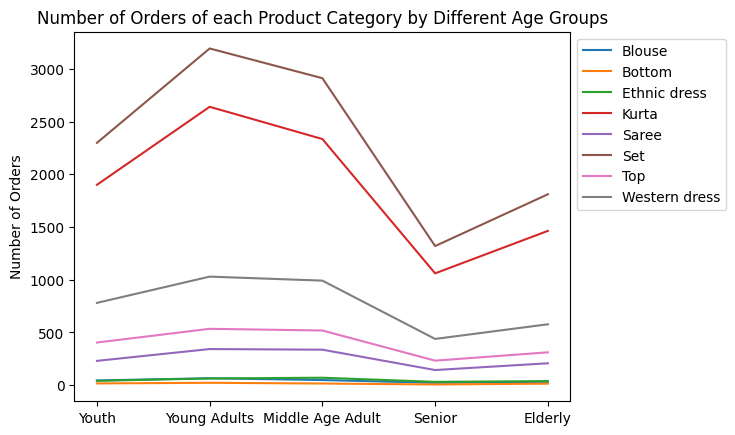

In [114]:
## Group by age group and category for lineplot
df = data.groupby(['Age Group','Category'])['Quantity'].agg(['sum'])

plt.title("Number of Orders of each Product Category by Different Age Groups")
sns.lineplot(data=df, x='Age Group', y='sum', hue='Category')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.ylabel("Number of Orders")
plt.xlabel("")

## Conclusion
As shown in above graph, Set and kurta are still the best selling product categories in all age groups, along with blouse, bottom and ethnic dresses having lower number of orders. So we can say that there is no specific preference of product category by age group.